In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import cv2 

In [2]:
class segmentation:
    def __init__(self,r,th=5,noise_acc=15,gap=1):
        self.r=r
        self.th=th
        self.noise_acc=noise_acc
        self.gap=gap
        self.h,self.w=r.shape
        self.imax=r.max()
        self.imin=r.min()
    
    def clear_noise(self):
        """
                 remove the pixels with small accuracy to make the process easier
                   inputs =>
                            r: Rimage
                            noise_acc: minimum accuracy per color degree
                   output =>
                            r: processed Rimage
        """
        unique , counts =np.unique(self.r.reshape(self.h*self.w),return_counts=True)
        for uni , count in zip( unique , counts) :
                if count < self.noise_acc:
                     self.r[self.r==uni]=0
        return self.r 
    
    def split_gap(self):
        """
                split the pixels into groups based on the gap between
                input =>
                             r: Rimage
                             gap: the maximum size between two pixels 
                output=> 
                             grps: list of groups
     
        """
        
        arr=np.unique(self.clear_noise().reshape(self.h*self.w))
        arr.sort()
        grps = [[arr[0]]]
        for i in arr[1:]:
            if abs(i - grps[-1][-1]) <= self.gap:
                grps[-1].append(i)
            else:
                grps.append([i])
        return grps
    def split_into_region(self,one,th):
            """
                split groups that had a large scale
                inputs=>
                        arr:Rimage
                        much: threshold
                output=>
                        region to merge 
      
            """
            ar=np.array(one)
            parts=ar.size//th
            if ar.size%th!=0:    
                shayt=ar.size-parts*th
                parts=parts+1
                toadd=parts*th - ar.size
                last=np.ones(toadd)*ar[-1]
                ar=np.concatenate((ar,last))
            return np.split(ar,parts)   
    def orga_regions(self):
            """
            organise the regions, width of th from the mean in both sides  
            inputs=>
                    arr:Rimage
                    th: threshold
            output=>
                    final regions to merge 

            """
            tmp=list()
            for one in self.split_gap():
                if len(one) > 2*self.th:
                    regions=self.split_into_region(one,2*self.th+1)
                    for i in range(len(regions)):
                        tmp.append(regions[i])
                else:
                    tmp.append(np.array(one))
            return tmp
        
    def segment(self):
            """
            regions in img

            output=>
                      array of image containt  region per elt 


            """
            
            im=[]
            for i in self.orga_regions():
                tat=np.abs(self.r-i.mean()).reshape(self.h,self.w)
                mask=tat < self.th
                iprim=int((i.mean()-self.imin)*255/(self.imax-self.imin))
                tat=(mask*np.ones(self.r.shape))*iprim
                im.append(tat)
            return im

## Import the img

In [7]:
image = cv2.imread('1pand_RGB.tif')
b,g,r=cv2.split(image)
h,w=r.shape
test=cv2.imread('regions.png')

## Create the instance and call the segment func.

In [8]:
seg=segmentation(r,th=10,noise_acc=30)
im=seg.segment()

## Plot the regions

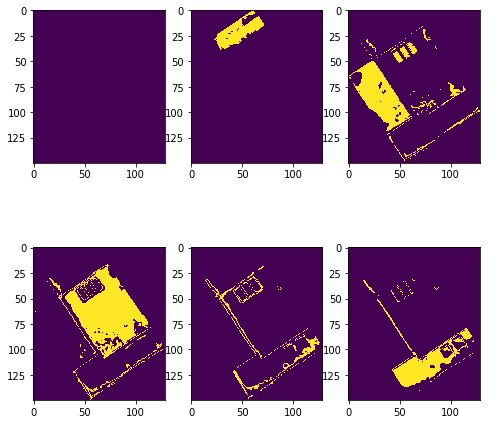

In [14]:
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(im[i-1])
